### **Setup Environment, Compile C++ Codes, and Import Dependencies**

This assignment requires us to understand and apply traditional image processing techniques. Considering the efficiency of pixel traversal, I plan to use C++ as the main language and then package it into a Python package to provide an API for use in a Python notebook. I am using the third-party library pybind11 to package the C++ code. If the packaging doesn’t work, you can place the provided package in the modules folder; this package is simply a compilation of the C++ code under the scripts directory.

In [3]:
!python compile.py

running build_ext
copying build\lib.win-amd64-cpython-312\image_processing.cp312-win_amd64.pyd -> 
Removed existing file: modules\image_processing.cp312-win_amd64.pyd
Moved image_processing.cp312-win_amd64.pyd to modules

Success!


In [4]:
from modules import *

### **Image Processing**

Before proceeding with image processing, I encapsulated an `Image` class to store information about the image, including its height, width, bytes per pixel, raw data, and so on. I then specified that the methods for image processing must be static and return a new image to ensure that the original image information remains unchanged. This principle will always apply: the image's data is read-only and cannot be modified.

For detailed API information, please refer to the `README.md` file.

---

#### **[Problem 1: Geometric Modification]**

- **Special Effect via Compound Linear Geometric Modification**

    Many times we will carry out basic geometric modification of the image, such as rotation, stretching, translation, below I use a special effect to show the effect of each geometric modification.

    ## Assumptions:
    - The original coordinates of a point are $(x, y)$.
    - The center of the image is $(c_x, c_y)$.
    - Time is $t$.
    - Shrinkage rate is $s$ (percentage per second, expressed as a decimal).
    - Rotation speed is $\theta$ degrees per second (clockwise).
    - Translation speed is $m$ pixels per second in the southeast direction.

    ### 1. Translation (Southeast)
    The point moves by $m \cdot t$ pixels in both $x$ and $y$ directions:
    $$
    x_{\text{trans}} = x + m \cdot t
    $$
    $$
    y_{\text{trans}} = y + m \cdot t
    $$

    ### 2. Scaling (Minification)
    The point shrinks towards the center of the image with rate $s$:
    $$
    x_{\text{scaled}} = c_x + (x - c_x) \cdot (1 - s \cdot t)
    $$
    $$
    y_{\text{scaled}} = c_y + (y - c_y) \cdot (1 - s \cdot t)
    $$

    ### 3. Rotation (Clockwise)
    The point rotates around the center by $\theta \cdot t$ degrees:
    - Convert degrees to radians:
    $$
    \theta_{\text{rad}} = \frac{\theta \cdot t \cdot \pi}{180}
    $$
    - Apply the rotation matrix:
    $$
    x_{\text{rotated}} = c_x + (x - c_x) \cdot \cos(\theta_{\text{rad}}) + (y - c_y) \cdot \sin(\theta_{\text{rad}})
    $$
    $$
    y_{\text{rotated}} = c_y - (x - c_x) \cdot \sin(\theta_{\text{rad}}) + (y - c_y) \cdot \cos(\theta_{\text{rad}})
    $$

    We can get the final result by bringing in the given values. The result is shown below. It is important to note that normal images may lose data after rotation because they are beyond the image boundaries, but I added padding to the images in order to preserve this rotated data, so in the following realistic images are not really relative sizes but stretched sizes, and the real sizes of each image I have labeled in parentheses. The end result is:
    - At t=5 seconds: The image should shrink by 15%, rotate by 25 degrees, and 
    translate by 10 pixels.
    - At t=20 seconds: The image should shrink by 60%, rotate by 100 degrees, 
    and translate by 40 pixels.

    NOTES: To achieve the transition effect of non-complete pixels, I used the `bilinear interpolation` method to do so.

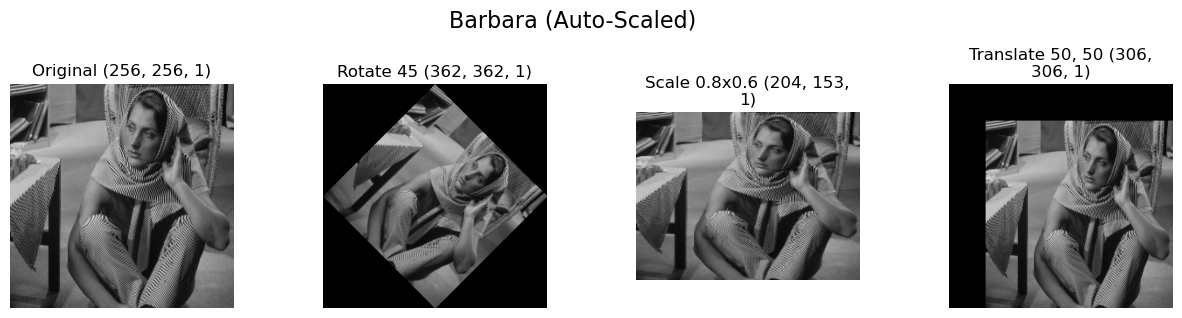

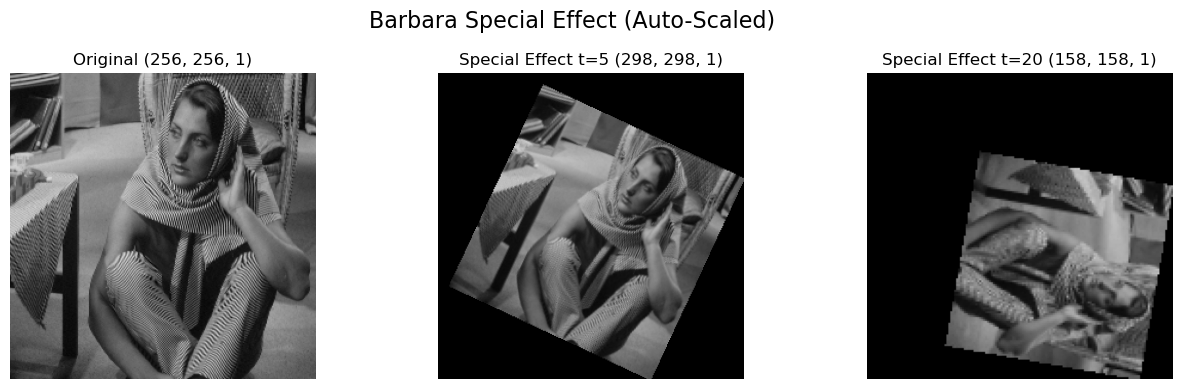

In [ ]:
# Special Effect via Compound Linear Geometric Modification

barbara = Image(256, 256, 1)
barbara.load("images/HW3/barbara.raw")

barbara_rotate = Image.rotate(barbara, 45, "bilinear")
barbara_scale = Image.scale(barbara, 0.8, 0.6, "bilinear")
barbara_translate = Image.translate(barbara, 50, 50, "bilinear")

show_images([barbara, barbara_rotate, barbara_scale, barbara_translate], [f"Original {barbara.raw_data.shape}", f"Rotate 45 {barbara_rotate.raw_data.shape}", f"Scale 0.8x0.6 {barbara_scale.raw_data.shape}", f"Translate 50, 50 {barbara_translate.raw_data.shape}"], "Barbara (Auto-Scaled)")

# Special Effect via Compound Linear Geometric Modification
def special_effect(img: Image, s: float, theta: float, m: int) -> Image:
    img = Image.scale(img, 1 - s, 1 - s, "bilinear")
    img = Image.rotate(img, theta, "bilinear")
    img = Image.translate(img, m, m, "bilinear")
    
    return img
    
velocities = {
    "s": 0.03,
    "theta": 5,
    "m": 2
}

barbara_special_t5 = special_effect(barbara, velocities["s"] * 5, velocities["theta"] * 5, velocities["m"] * 5)
barbara_special_t20 = special_effect(barbara, velocities["s"] * 20, velocities["theta"] * 20, velocities["m"] * 20)

show_images([barbara, barbara_special_t5, barbara_special_t20], [f"Original {barbara.raw_data.shape}", f"Special Effect t=5 {barbara_special_t5.raw_data.shape}", f"Special Effect t=20 {barbara_special_t20.raw_data.shape}"], "Barbara Special Effect (Auto-Scaled)")

- **Spatial Warping Techniques**

    There are times when we will warp an image, from a simple realization of the effect, to some stretching at different angles. Let's say that the latest Apple products have cameras that allow you to get both a flat view and a top view from one camera, which uses image warping.

    Let's say in the following case, we want the rectangular image to wrap into a circle, then it is very important that the pixels on the edges are the same, then we make a ratio based on the distance from the edge to the center of the circle, and then using this ratio, we make a linear CLAMP on each pixel point on the line, and finally we realize the WARPING from the rectangle to the circle.

    ## Variables:
    - Rectangular image dimensions: $w$ (width) and $h$ (height).
    - Circular image parameters:
    - Center at $(c_x, c_y)$.
    - Radius $r = \min\left(\frac{w}{2}, \frac{h}{2}\right)$.
    - A pixel in the rectangle is located at $(x, y)$.
    - A corresponding pixel in the circle will map to $(u, v)$.

    ### 1. Define Polar Coordinates
    We calculate the **polar coordinates** of a pixel $(x, y)$ in the rectangular image relative to its center $(c_x, c_y)$:

    1. **Angle** $\theta$ (azimuthal angle around the circle):
    $$
    \theta = \arctan2(y - c_y, x - c_x)
    $$

    2. **Distance from the center** $r_{\text{rect}}$:
    $$
    r_{\text{rect}} = \sqrt{(x - c_x)^2 + (y - c_y)^2}
    $$

    ### 2. Map Distance to Circular Radius
    To map the rectangular pixel to the circular domain, scale the distance $r_{\text{rect}}$ to fit within the circle's radius $r$. This involves clamping $r_{\text{rect}}$ to the maximum allowed value:
    $$
    r_{\text{circle}} = r \cdot \text{CLAMP}\left(\frac{r_{\text{rect}}}{r}, 0, 1\right)
    $$

    ### 3. Compute Circular Coordinates
    Using the scaled radius $r_{\text{circle}}$ and the angle $\theta$, compute the coordinates in the circular domain:
    $$
    u = c_x + r_{\text{circle}} \cdot \cos(\theta)
    $$
    $$
    v = c_y + r_{\text{circle}} \cdot \sin(\theta)
    $$

    The detailed implementation effect is shown in the image below:
    <div style="text-align: center;">
    <img src="images/circle_wraping.jpg" alt="Implementation" width="400"/>
    </div>

    The same applies to the **inverse** from circle to rectangle, but due to the reduction of pixels, I use the “nearest” method to find the missing pixel information, so the final inverse is different from the original image, and by comparing the two images, we get an `MSE` of `82.79`.

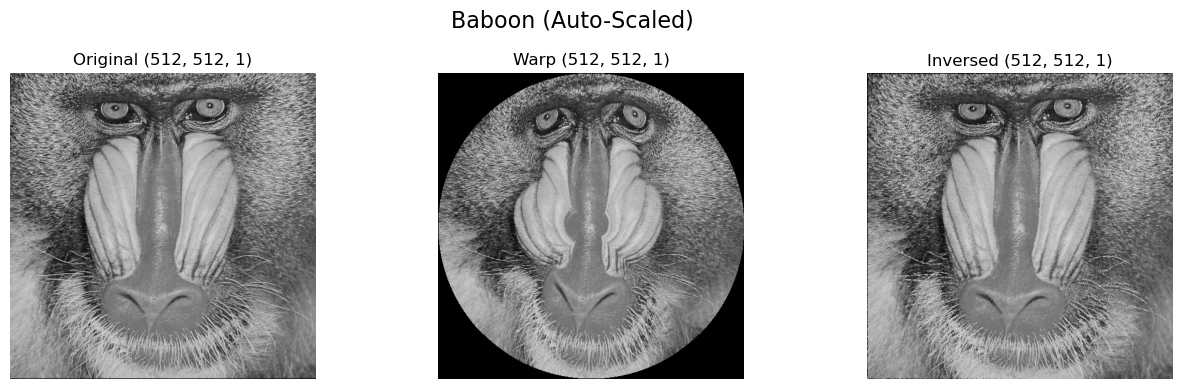

The MSE between the original and inversed image is 82.79065704345703


In [4]:
# Spatial warping techniques

baboon = Image(512, 512, 1)
baboon.load("images/HW3/baboon.raw")

baboon_warp = Image.circle_warp(baboon, False)
baboon_warp_inverse = Image.circle_warp(baboon_warp, True)

show_images([baboon, baboon_warp, baboon_warp_inverse], [f"Original {baboon.raw_data.shape}", f"Warp {baboon_warp.raw_data.shape}", f"Inversed {baboon_warp_inverse.raw_data.shape}"], "Baboon (Auto-Scaled)")
print("The MSE between the original and inversed image is", compare_images(baboon, baboon_warp_inverse))

#### **[Problem 2: Texture Analysis and Segmentation]**

- **Texture Classification**

    There are all kinds of materials in life, plastic, wool, wood and so on. Each material has different characteristics. Identical or similar materials usually have similar characteristics. We can easily categorize some materials with the naked eye. However, considering computer image processing, it is not so simple. Here is my classification process for 15sample images with the following steps:

    ### 1. Compute Law's Filters

    Given two 3x1 vectors 
    $$
    A = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix}, \quad
    B = \begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix},
    $$
    the outer product $ A \times B^T $ is a 3x3 matrix computed as:

    $$
    A \times B^T = 
    \begin{bmatrix}
    a_1 b_1 & a_1 b_2 & a_1 b_3 \\
    a_2 b_1 & a_2 b_2 & a_2 b_3 \\
    a_3 b_1 & a_3 b_2 & a_3 b_3
    \end{bmatrix}
    $$

    Similarly, for the vectors $ L_3 $, $ E_3 $, and $ S_3 $, we can compute the outer products:

    $$
    L_3 \times E_3^T, \quad L_3 \times S_3^T, \quad E_3 \times S_3^T
    $$

    In each case, simply take the corresponding elements of the vectors and perform the multiplication as shown in the general outer product formula.

    ### 2. Convolve and Get Features

    By convolving all the law filters generated above and then taking its energy for each convolution result, we have condensed the result of each law filter for the current image into a feature, so that we obtain an array of features. By doing this for each image and then aggregating it with the kmeans method, we successfully classified 15 sample images in groups of 3.

    Notes: To increase the recognition, I put extra min-max values as separate features for each image. meanwhile, for kmeans I used the open source library on github, here is the link: [https://github.com/marcoscastro/kmeans](https://github.com/marcoscastro/kmeans)


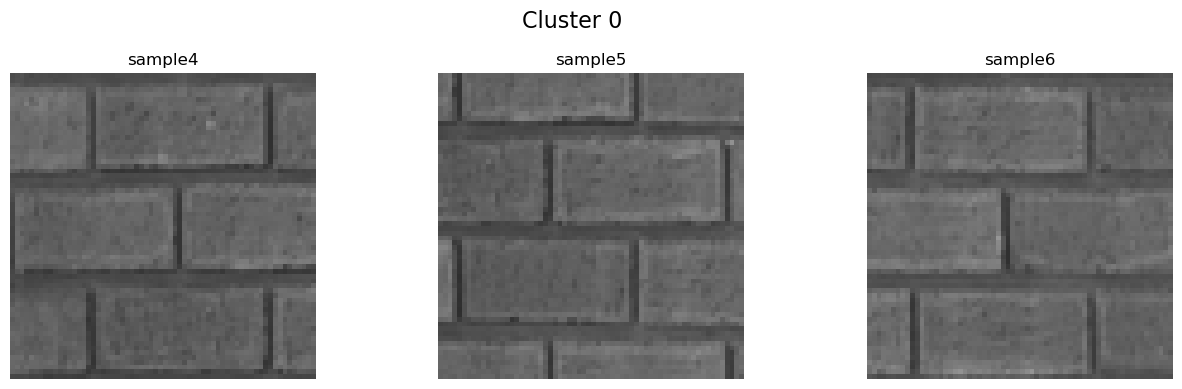

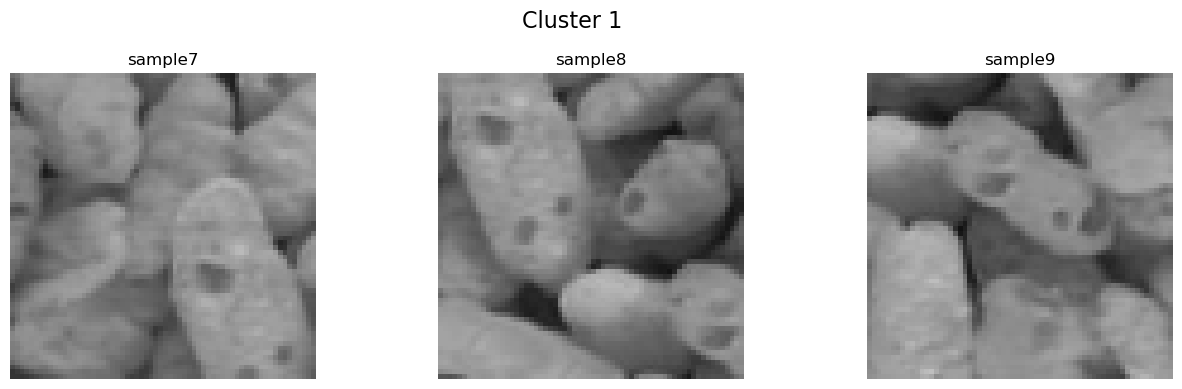

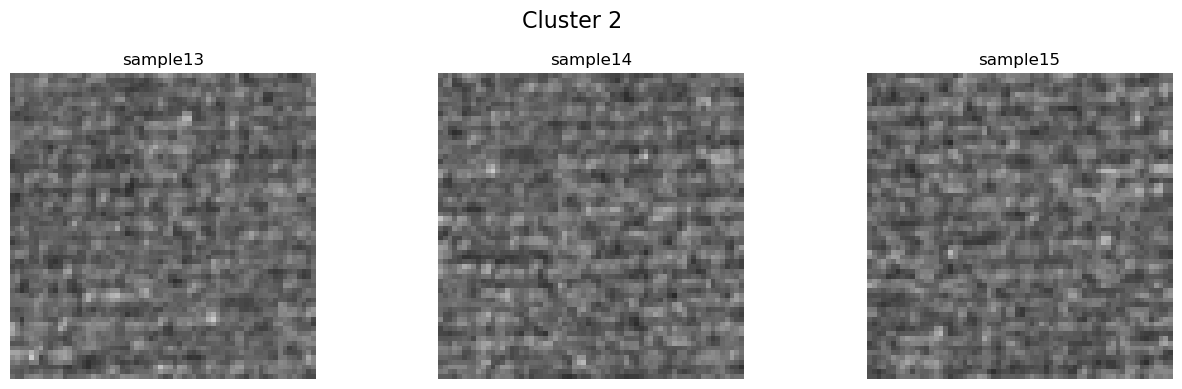

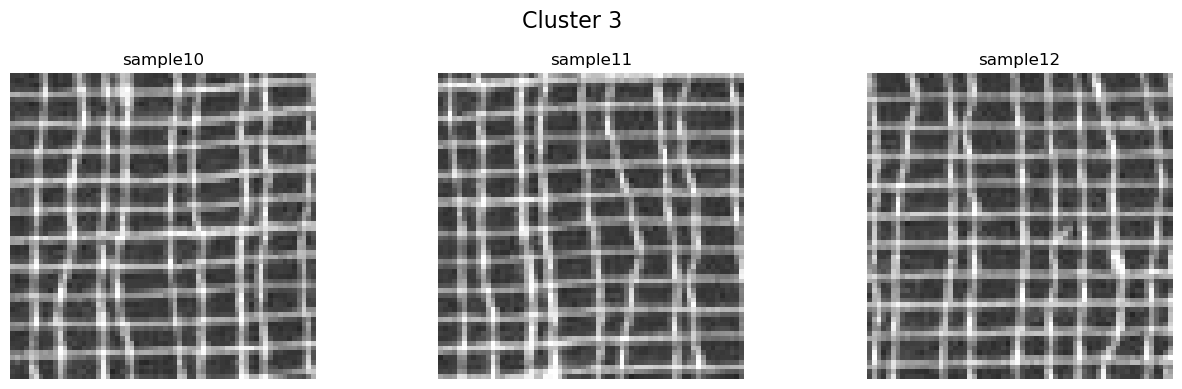

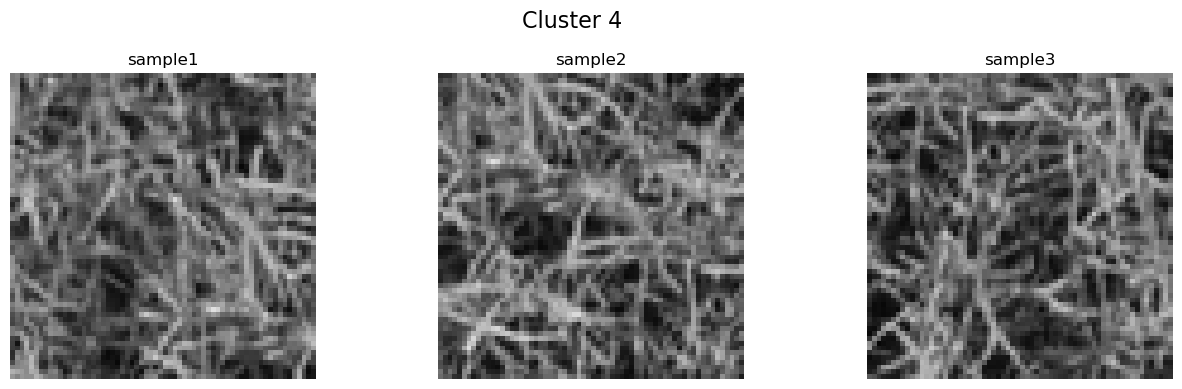

In [70]:
# Texture Classification

sample1 = Image(64, 64, 1)
sample1.load("images/HW3/sample1.raw")
sample2 = Image(64, 64, 1)
sample2.load("images/HW3/sample2.raw")
sample3 = Image(64, 64, 1)
sample3.load("images/HW3/sample3.raw")
sample4 = Image(64, 64, 1)
sample4.load("images/HW3/sample4.raw")
sample5 = Image(64, 64, 1)
sample5.load("images/HW3/sample5.raw")
sample6 = Image(64, 64, 1)
sample6.load("images/HW3/sample6.raw")
sample7 = Image(64, 64, 1)
sample7.load("images/HW3/sample7.raw")
sample8 = Image(64, 64, 1)
sample8.load("images/HW3/sample8.raw")
sample9 = Image(64, 64, 1)
sample9.load("images/HW3/sample9.raw")
sample10 = Image(64, 64, 1)
sample10.load("images/HW3/sample10.raw")
sample11 = Image(64, 64, 1)
sample11.load("images/HW3/sample11.raw")
sample12 = Image(64, 64, 1)
sample12.load("images/HW3/sample12.raw")
sample13 = Image(64, 64, 1)
sample13.load("images/HW3/sample13.raw")
sample14 = Image(64, 64, 1)
sample14.load("images/HW3/sample14.raw")
sample15 = Image(64, 64, 1)
sample15.load("images/HW3/sample15.raw")

law_filter_size = 5
num_of_clusters = 5
max_iterations = 200

# Cluster the samples
samples = [sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9, sample10, sample11, sample12, sample13, sample14, sample15]
cluster_results = Image.texture_cluster(samples, law_filter_size, num_of_clusters, max_iterations)

# Show the classification
classification = [[] for _ in range(num_of_clusters)]
for i in range(len(samples)):  
    for j in range(num_of_clusters):
        if cluster_results[i] == j:
            classification[j].append({f"sample{i + 1}" :samples[i]})
             
for cluster_id, images in enumerate(classification):
    show_images([img for sample in images for img in sample.values()], 
                [img for sample in images for img in sample.keys()], 
                f"Cluster {cluster_id}")


- **Texture Segmentation 1**

    With the above image classification, we can do the texture segmentation of the picture, the specific method is, we can divide the whole picture into some small patches, and then these patches are treated as a separate picture, and then this way we will get a lot of pictures, and then these pictures for texture classification, and then according to the obtained cluster group, to the color of the picture color.

    $$
    C(clusterID) = \left\lfloor \frac{clusterID}{255} \times (numOfClusters - 1) \right\rfloor
    $$

    Based on the final result on `Comb1` we find that it works relatively best when I take `patch_size = 16`, which preserves the number of patches and ensures that each patch has enough information. However, we found that the top-left, center, and top-right images segmented the best, but the bottom-left and bottom-right images are less able to distinguish clearly. **I think the reason: there are a lot of image junctions**, these patches will be difficult to be classified into a class, so they will confuse the overall classification structure, especially when kmeans converges, these patches are easy to be classified as a whole, so that the two images of the lower left and by the lower can not be well distinguished.

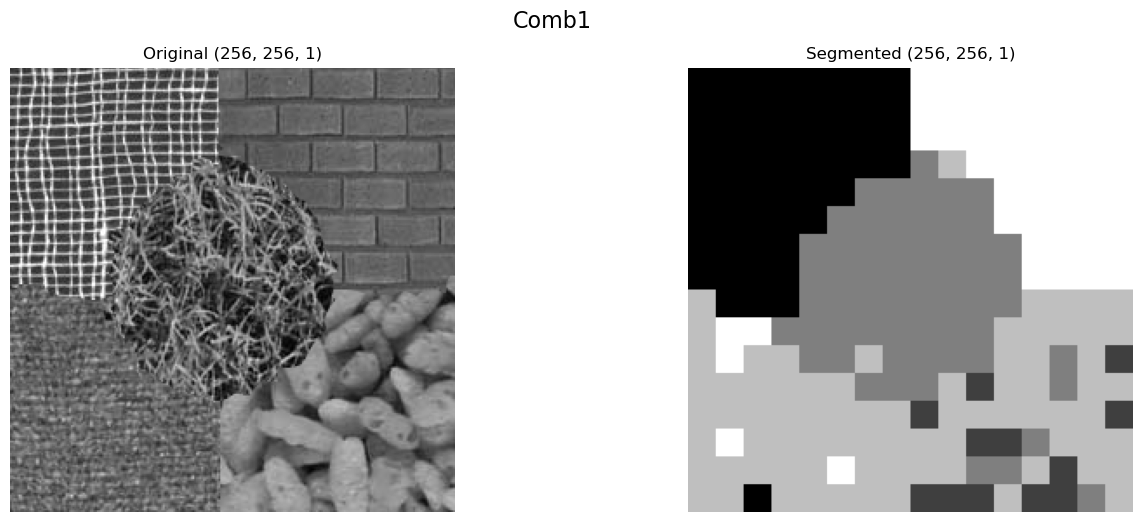

In [40]:
# Texture Segmentation

comb1 = Image(256, 256, 1)
comb1.load("images/HW3/comb1.raw")

law_filter_size = 5
num_of_clusters = 5
patch_size = 16
max_iterations = 200

comb1_segmented = Image.texture_segment(comb1, 0, law_filter_size, patch_size, num_of_clusters, max_iterations)

show_images([comb1, comb1_segmented], [f"Original {comb1.raw_data.shape}", f"Segmented {comb1_segmented.raw_data.shape}"], "Comb1")

- **Texture Segmentation 2**

    According to the results of `Comb2`, the top left, top right and bottom right are classified successfully at `patch_size = 32`, but this classification effect is hard to distinguish the top left and bottom left materials, so much so that the results of my attempts from `patch_size 16-32` are not too good. I think there are the following reasons: 
    
    1. the material of the upper left and lower left are very similar in itself, which indeed, if we people don't look carefully it's hard to distinguish the difference between these two, and their features are more similar, so much so that the result of obtaining ENERGY FEATURES with LAW FILTER is approximated; 
    
    2. the similarity of these two materials is much greater than the similarity of the materials at the junction of the image, so much so that they The two materials are classified into a cluster (this is not reflected when `patch_size = 16 or 32`, because 16 or 32 can be divided by 256, but it is especially obvious when other patch_sizes are used).

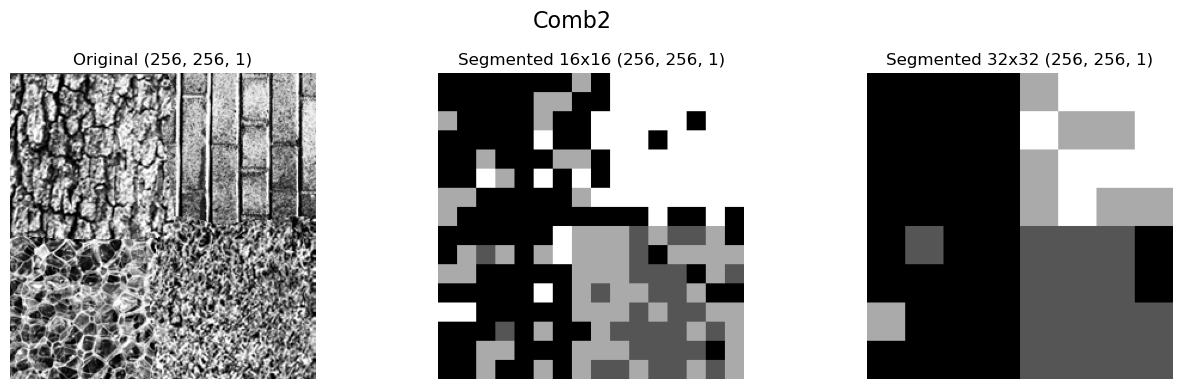

In [ ]:
# Texture Segmentation

comb2 = Image(256, 256, 1)
comb2.load("images/HW3/comb2.raw")

law_filter_size = 5
num_of_clusters = 4
patch_size1 = 16
patch_size2 = 32
max_iterations = 200

comb2_segmented1 = Image.texture_segment(comb2, 0, law_filter_size, patch_size1, num_of_clusters, max_iterations)
comb2_segmented2 = Image.texture_segment(comb2, 1, law_filter_size, patch_size2, num_of_clusters, max_iterations)

show_images([comb2, comb2_segmented1, comb2_segmented2], [f"Original {comb2.raw_data.shape}", f"Segmented 16x16 {comb2_segmented1.raw_data.shape}", f"Segmented 32x32 {comb2_segmented2.raw_data.shape}"], "Comb2")


#### **[Problem 3: Document Processing (Optical Character Recognition – OCR)]**

In life we are always inseparable from the character recognition, let's say the simplest pdf in the text extraction, many times we will use, but this contains the character recognition. The following is a very simple decision tree based character recognition method.

- **Image Segmentations**

    Often an image contains multiple independent characters, we need to extract these characters individually, which requires the use of image segmentation. The segmentation process uses a flood-fill method to identify and label connected regions in a binary image. The following is the Flood-Fill Algorithm that implements the image segementation.

    For each pixel $ I(x, y) = 255 $ and $ L(x, y) = 0 $, perform a flood-fill:

    - Initialize a queue:

        $$ Q \gets [(x, y)] $$

    - While the queue is not empty:
        - Pop a pixel $ (x', y') $ from $ Q $.
        - Label the pixel:

        $$ L(x', y') = \text{label} $$

        - Add its 4-connected neighbors $ (x_\text{neighbor}, y_\text{neighbor}) $ to $ Q $ if:

        $$ 
        I(x_\text{neighbor}, y_\text{neighbor}) = 255 
        \quad \text{and} \quad 
        L(x_\text{neighbor}, y_\text{neighbor}) = 0 
        $$
    
    We preserve the length and width of the segmented image in order to preserve its original aspect ratio in subsequent training. In order to clarify the part of the segmentation, we gray-scale the picture and then binarized, and then take the inverse color to ensure that the character parts are pure white 255, the blank part is pure black 0. The segmented subimages graphes are shown below.

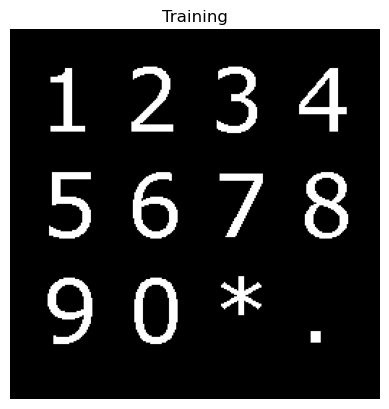

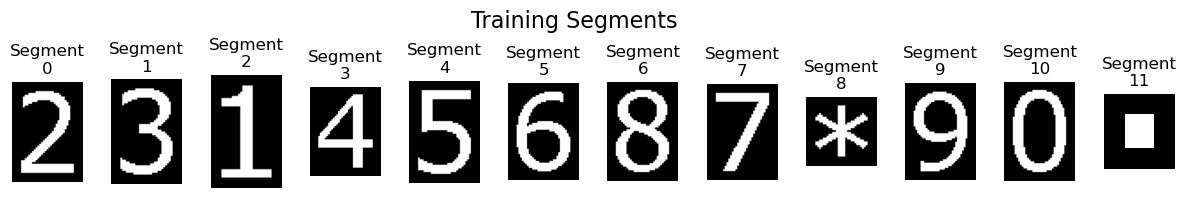

In [42]:
# Document Processing (Optical Character Recognition – OCR)

training = Image(256, 256, 3)
training.load("images/HW3/training.raw")
training = Image.gray_scale(training)
training = Image.fixed_dither(training, 0, 128)
training = Image.negative(training)

training_shear1 = Image.shear(training, 0.15, 0, "nearest")
training_shear2 = Image.shear(training, 0.3, 0, "nearest")

training_dilate1 = Image.dilate(training, 0, 1)
training_dilate2 = Image.dilate(training, 0, 2)

training_minifized1 = Image.scale(training, 0.8, 0.8, "nearest")
training_minimized2 = Image.scale(training, 0.5, 0.5, "nearest")

training_shear_minifized = Image.shear(training_minifized1, 0.15, 0, "nearest")
training_shear_dilate = Image.shear(training_dilate1, 0.15, 0, "nearest")
training_minified_dilate = Image.scale(training_dilate1, 0.8, 0.8, "nearest")

show_image(training, "Training")

segments = Image.segment(training, 16)
segments_shear1 = Image.segment(training_shear1, 16)
segments_shear2 = Image.segment(training_shear2, 16)
segments_dilate1 = Image.segment(training_dilate1, 16)
segments_dilate2 = Image.segment(training_dilate2, 16)
segments_minifized1 = Image.segment(training_minifized1, 16)
segments_minimized2 = Image.segment(training_minimized2, 16)
segments_shear_minifized = Image.segment(training_shear_minifized, 16)
segments_shear_dilate = Image.segment(training_shear_dilate, 16)
segments_minified_dilate = Image.segment(training_minified_dilate, 16)

show_images(segments, [f"Segment {i}" for i in range(len(segments))], "Training Segments")

- **Segments Feature Training**

    After getting the segments, I extracted the features for each segment, I used the following features in total: `aspect_ratio`, `area_rate`, `perimeter_rate`, `euler_number`, `spatial_moment_00`, `spatial_moment_01`, `spatial_moment_10`, `centroid` , `symmetry`, `circularity` and their purpose is respectively:

    1. **Aspect Ratio**: Measures the ratio of height to width, useful for distinguishing tall, narrow characters like '1' from wide ones like '0'.

    2. **Area Rate**: The proportion of pixels in the segment compared to its bounding box, helpful for identifying densely packed characters versus sparse ones.

    3. **Perimeter Rate**: Ratio of the perimeter to the bounding box dimensions, aiding in differentiating characters with complex outlines like '8' from simple ones like '1'.

    4. **Euler Number**: The number of connected components minus the number of holes, critical for identifying characters with loops (e.g., '8' vs. '7').

    5. **Spatial Moment $ M_{00} $**: Represents the total pixel intensity, useful for comparing the size and brightness of characters.

    6. **Spatial Moment $ M_{01} $**: Indicates vertical distribution of pixel intensity, helping to locate the vertical balance of the character.

    7. **Spatial Moment $ M_{10} $**: Indicates horizontal distribution of pixel intensity, helping to locate the horizontal balance of the character.

    8. **Centroid**: The geometric center of the segment, useful for normalizing character positioning. It is essential to distinguish characters between '9' and '6'

    9. **Symmetry**: Measures the reflectional symmetry of the character, important for distinguishing symmetrical characters like '8' from asymmetrical ones like '7'.

    10. **Circularity**: The ratio of the square of the perimeter to the area, aiding in recognizing round characters like '0' versus angular ones like '3'.

    After using Bitquads matrix alignment and window sliding to find the number of maps, it is easy to compute the above features, however, to make sure that the training set is sufficient, I `shear`, `diliate`, and `minify` the `training` images to make sure that some distortions are also possible. to ensure that some distorted images can also be recognized. I am using random forest as my decision tree forest model for training, the maximum depth parameter I provided 100, as below we can get the distribution of `feature importance`. We can find that the proportion related to spatial distribution is relatively high, because these features are the key to distinguish different characters.

Feature ranking:
1. Perimeter Rate (0.15035773032385594)
2. Aspect Ratio (0.1489073877273693)
3. Centroid Y (0.13182467435129147)
4. Euler Number (0.11854501542911142)
5. Centroid X (0.085756265671612)
6. Circularity (0.08257576789109994)
7. Spatial Moment 01 (0.06457482135498244)
8. Spatial Moment 00 (0.059657116138876254)
9. Symmetry (0.056441379287784664)
10. Area Rate (0.052181125070730944)
11. Spatial Moment 10 (0.04917871675328549)


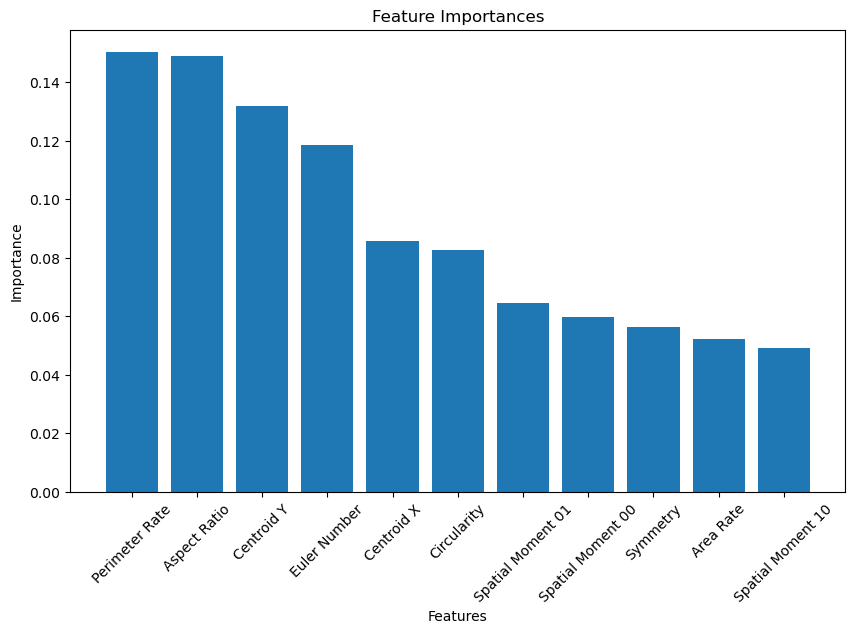

In [47]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

def get_features(image: Image) -> list:
    aspect_ratio = image.get_aspect_ratio()
    area_rate = image.get_area_rate()
    perimeter_rate = image.get_perimeter_rate()
    euler_number = image.get_euler_number(True)
    spatial_moment_00 = image.get_spatial_moment(0, 0)
    spatial_moment_01 = image.get_spatial_moment(0, 1)
    spatial_moment_10 = image.get_spatial_moment(1, 0)
    centroid = image.get_centroid()
    symmetry = image.get_symmetry()
    circularity = image.get_circularity()
    
    return [aspect_ratio, area_rate, perimeter_rate, euler_number, spatial_moment_00, spatial_moment_01, spatial_moment_10, centroid[0], centroid[1] , symmetry, circularity]

labels = np.array(['2', '3', '1', '4', '5', '6', '8', '7', '*', '9', '0', '.']) # Example labels

# Extract features from segments using the function
features = np.array([get_features(segment) for segment in segments])
features_shear1 = np.array([get_features(segment) for segment in segments_shear1])
features_shear2 = np.array([get_features(segment) for segment in segments_shear2])
features_dilate1 = np.array([get_features(segment) for segment in segments_dilate1])
features_dilate2 = np.array([get_features(segment) for segment in segments_dilate2])
features_minifized1 = np.array([get_features(segment) for segment in segments_minifized1])
features_maximized2 = np.array([get_features(segment) for segment in segments_minimized2])
features_shear_minifized = np.array([get_features(segment) for segment in segments_shear_minifized])
features_shear_dilate = np.array([get_features(segment) for segment in segments_shear_dilate])
features_minified_dilate = np.array([get_features(segment) for segment in segments_minified_dilate])

combined_features = np.concatenate((features, features_shear1, features_shear2, features_dilate1, features_dilate2, features_minifized1, features_maximized2, features_shear_minifized, features_shear_dilate, features_minified_dilate), axis=0)
combined_labels = np.concatenate((labels, labels, labels, labels, labels, labels, labels, labels, labels, labels), axis=0)

# Train decision tree classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=1000)
clf.fit(combined_features, combined_labels)

# Features Importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = ["Aspect Ratio", "Area Rate", "Perimeter Rate", "Euler Number", "Spatial Moment 00", "Spatial Moment 01", "Spatial Moment 10", "Centroid X", "Centroid Y", "Symmetry", "Circularity"]

print("Feature ranking:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


- **ORC Test and Validation 1**

    Moving on to the testing session, I started with test set 1. The characters in this test set were all shear twisted, but because my training set included some shear processing, the results were relatively good, except for the character `'5'` which was recognized as `'2'`, the other characters were recognized correctly. The following are my illustrations: 
    
    **REASON:** character '5' is recognized as '2' is that they are basically the same in terms of `perimeter`, `centroid`, and `aspect ratio`, which are the big weighted FEATURES, such that they are misrecognized in the final recognition. 
    
    **POSSIBLE IMPROVEMENT:** add a feature that determines whether the opening is to the left or to the right, to distinguish 5 from 2.

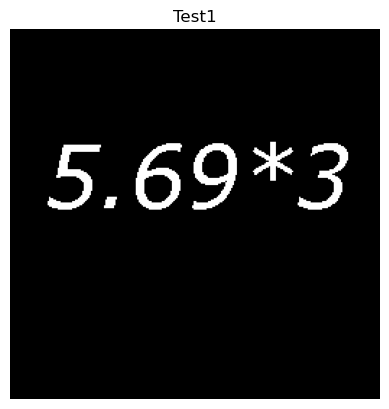

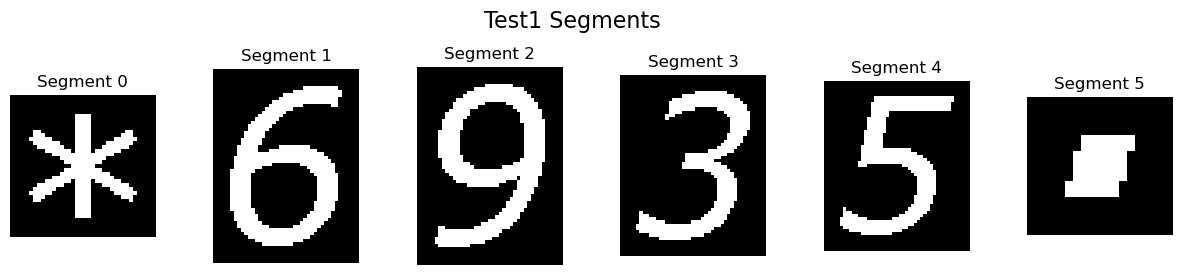

array(['*', '6', '9', '3', '2', '.'], dtype='<U1')

In [67]:
test1 = Image(256, 256, 3)
test1.load("images/HW3/test1.raw")
test1 = Image.gray_scale(test1)
test1 = Image.fixed_dither(test1, 0, 128)
test1 = Image.negative(test1)

show_image(test1, "Test1")

segments1 = Image.segment(test1, 16)
show_images(segments1, [f"Segment {i}" for i in range(len(segments1))], "Test1 Segments")

# Extract features from segments using the function
features = [get_features(segment) for segment in segments1]
features = np.array(features)

clf.predict(features)

- **ORC Test and Validation 2**

    Next is the second test set, which has far more transformations than the first, but because my training set contains diliate and shear, some of the 'slanting' and 'fattening' character transformations are able to be handled. However, this time the recognition went wrong wrongly by recognizing '*' as '0' as well as recognizing '8' as '7' I think the problem is as follows:
    
    1. **'*' recognized as '0'**: because the resolution of the picture is very small, resulting in * itself, the `perimeter rate`, `centroid`, `aspect ratio` and 0 similar, although their Euler's number is not the same, due to the image transformation of this time the drastic, did not recognize successfully.
    2. **'8' was recognized as '7'**: which I think was completely distorted due to the fact that the 8 in the original image was very small, and I didn't have a small enough 8 in my training set, resulting in inaccurate pixel accuracy.

    Both of the above points are due to the accuracy problem caused by the **image being too small**, I think the solution is not only to increase the training set of small resolution images, but also to add some size-independent features such as skeleton.

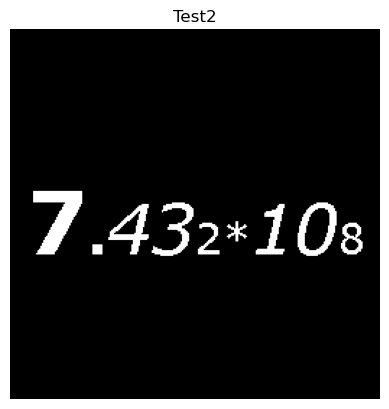

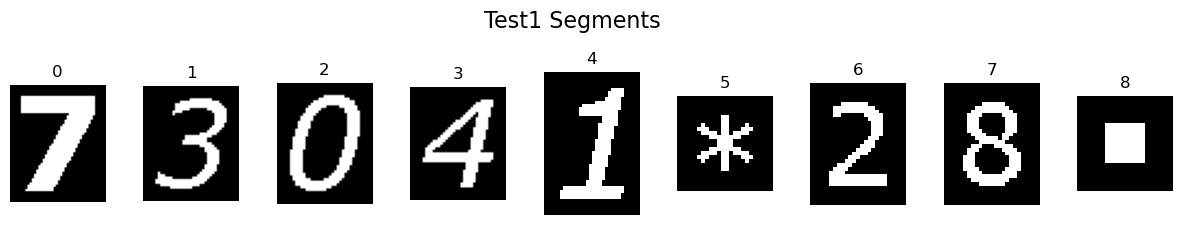

array(['7', '3', '0', '4', '1', '0', '2', '7', '.'], dtype='<U1')

In [ ]:
test2 = Image(256, 256, 1)
test2.load("images/HW3/test2.raw")
test2 = Image.gray_scale(test2)
test2 = Image.fixed_dither(test2, 0, 128)
test2 = Image.negative(test2)

show_image(test2, "Test2")

segments2 = Image.segment(test2, 16)
show_images(segments2, [f"{i}" for i in range(len(segments2))], "Test1 Segments")

# Extract features from segments using the function
features = [get_features(segment) for segment in segments2]
features = np.array(features)

clf.predict(features)

- **ORC Think Beyond**

    After running through the recognition of the numbers, we can try to recognize some of the letters, even though the current letters are not present in the training set, but we can discuss what FEATURES are actually dominating by analyzing why these letters are recognized as these numbers:

    1. **(Top part of the letter i) → .**:
    The top part of i resembles a small dot, closely matching the shape and features of . such as `aspect_ratio` and `area_rate`.

    2. **h → 2, k → 2**:
    The shapes of h and k have vertical strokes and curves, which partially overlap with the features of 2, particularly `circularity` and `symmetry`.

    3. **T → 7**:
    Both T and 7 share a horizontal line and vertical structure, with similar `aspect_ratio` and `perimeter_rate`, leading to this misclassification.

    4. **n → 4 and \***:
    The curve of n resembles part of 4, and its overall structure might align with the star shape * based on `spatial distribution`.

    5. **(Bottom part of the letter i) → 1**:
    The bottom of i is a straight vertical stroke, similar to 1, resulting in a match based on `aspect_ratio`.

    6. **d → 6**:
    The round part of d corresponds to the circular feature of 6, and their `circularity` and `symmetry` align closely.

    7. **B → 8**:
    Both B and 8 have a double-loop structure, making their `circularity` and `spatial moments` closely match.

    8. **e → 4, o → 4**:
    The curved shapes of e and o share geometric similarities with 4, especially in terms of `circularity` and `aspect_ratio`.

    9. **y → 7**:
    The structure of y, with a vertical stroke and downward curve, matches well with 7 in `aspect_ratio` and `symmetry`.

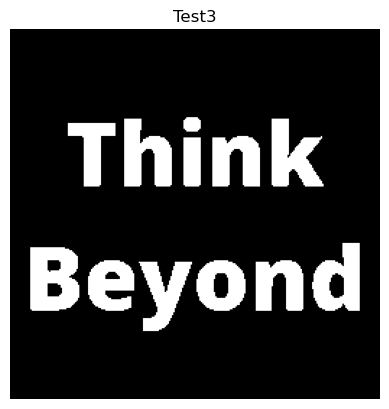

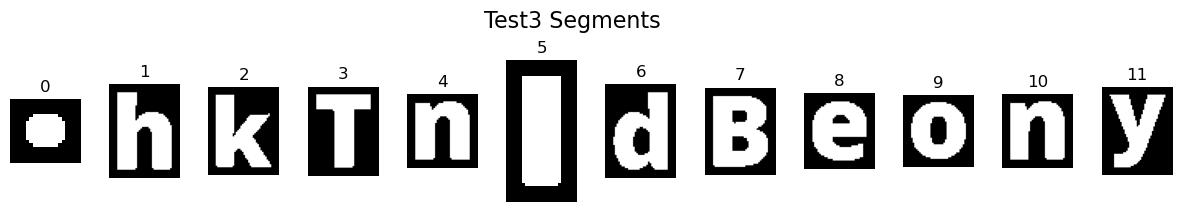

array(['.', '2', '2', '7', '*', '1', '6', '8', '4', '4', '*', '7'],
      dtype='<U1')

In [69]:
test3 = Image(256, 256, 3)
test3.load("images/HW3/test3.raw")
test3 = Image.gray_scale(test3)
test3 = Image.fixed_dither(test3, 0, 128)
test3 = Image.negative(test3)

show_image(test3, "Test3")

segments3 = Image.segment(test3, 16)
show_images(segments3, [f"{i}" for i in range(len(segments3))], "Test3 Segments")

# Extract features from segments using the function
features = [get_features(segment) for segment in segments3]
features = np.array(features)

clf.predict(features)